# Part e): Bias-variance trade-off and resampling techniques

### Reproduction of Bias-variance plot

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample


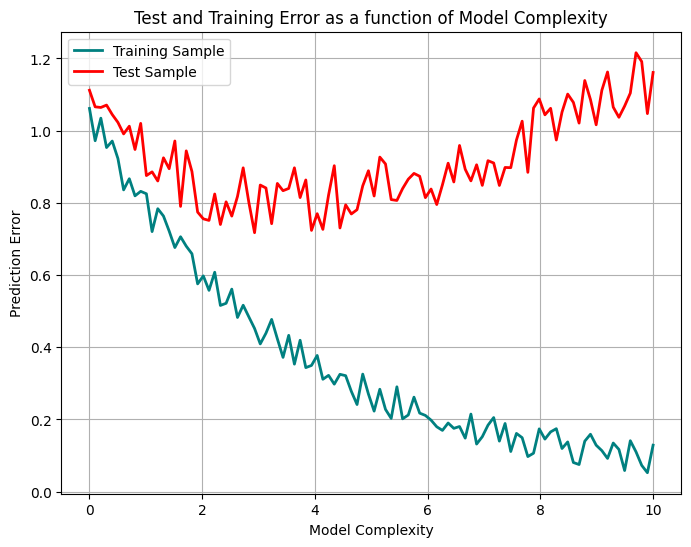

In [2]:
# Create data for model complexity and errors
model_complexity = np.linspace(0, 10, 100)

# Generate training and test error data
training_error = np.exp(-0.3 * model_complexity) + 0.1 * np.random.rand(100)
test_error = np.exp(-0.3 * model_complexity) + 0.1 * model_complexity + 0.2 * np.random.rand(100)

# Plot the data
plt.figure(figsize=(8, 6))
plt.plot(model_complexity, training_error, label="Training Sample", color='teal', linewidth=2)
plt.plot(model_complexity, test_error, label="Test Sample", color='red', linewidth=2)

# Add labels and title
plt.xlabel("Model Complexity")
plt.ylabel("Prediction Error")
plt.title("Test and Training Error as a function of Model Complexity")

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


### Rewriting the cost-function in terms of bias, variance and noise

We aim to show that this expression can be written as:

$\mathbb{E}[(y - \tilde{y})^2] = \text{Bias}[\tilde{y}] + \text{Var}[\tilde{y}] + \sigma^2$

We decompose the expected value $( \mathbb{E}[(y - \tilde{y})^2] )$ into bias, variance, and noise. To do this, let’s add and subtract $( \mathbb{E}[\tilde{y}] )$, the expected value of the prediction:

$y - \tilde{y} = \left( y - \mathbb{E}[\tilde{y}] \right) + \left( \mathbb{E}[\tilde{y}] - \tilde{y} \right)$

Now, we square both sides:

$(y - \tilde{y})^2 = \left( y - \mathbb{E}[\tilde{y}] \right)^2 + \left( \mathbb{E}[\tilde{y}] - \tilde{y} \right)^2 + 2\left( y - \mathbb{E}[\tilde{y}] \right)\left( \mathbb{E}[\tilde{y}] - \tilde{y} \right)$

Now, take the expectation $( \mathbb{E} )$ of both sides. First, note that $( \mathbb{E}[\tilde{y}] )$ is a constant, so:

$\mathbb{E}[(y - \tilde{y})^2] = \mathbb{E} \left[ (y - \mathbb{E}[\tilde{y}])^2 \right] + \mathbb{E} \left[ (\tilde{y} - \mathbb{E}[\tilde{y}])^2 \right] + 2 \mathbb{E} \left[ (y - \mathbb{E}[\tilde{y}]) (\mathbb{E}[\tilde{y}] - \tilde{y}) \right]$

The first term $( \mathbb{E}[(y - \mathbb{E}[\tilde{y}])^2] )$ is the variance of the true data around the expected prediction, which includes the bias term:

$\mathbb{E}[(y - \mathbb{E}[\tilde{y}])^2] = \text{Bias}[\tilde{y}]^2 + \sigma^2$



The second term $( \mathbb{E}[(\tilde{y} - \mathbb{E}[\tilde{y}])^2] )$ is the variance of the model:

$\mathbb{E}[(\tilde{y} - \mathbb{E}[\tilde{y}])^2] = \text{Var}[\tilde{y}]$


The cross-term expectation $( \mathbb{E}[(y - \mathbb{E}[\tilde{y}])(\mathbb{E}[\tilde{y}] - \tilde{y})] )$ is zero because $( y - \mathbb{E}[\tilde{y}] )$ and $( \tilde{y} - \mathbb{E}[\tilde{y}] $) are independent.


Thus, we can simplify the decomposition to:

$\mathbb{E}[(y - \tilde{y})^2] = \text{Bias}[\tilde{y}]^2 + \text{Var}[\tilde{y}] + \sigma^2$

### Bias-variance analysis of the Franke function 

To analyze the bias-variance trade-off, we can use the bootstrap resampling method. This method involves randomly sampling the training data with replacement to create multiple bootstrap samples. Each bootstrap sample is used to train a model, and the predictions from these models are averaged to obtain the final prediction. By repeating this process multiple times, we can estimate the bias and variance of the model.

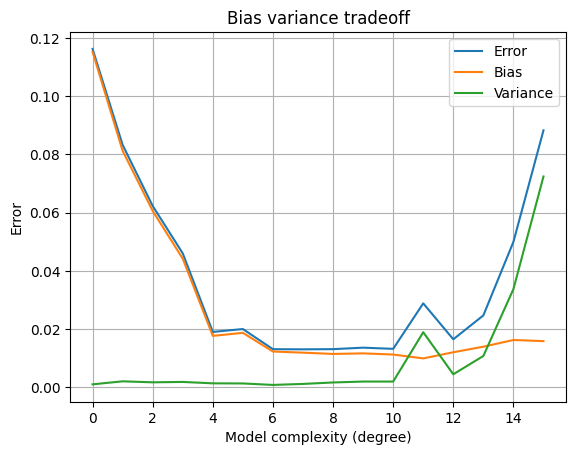

In [3]:
np.random.seed(2018)

n = 100
n_boostraps = 100
degree = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
noise = 1

# Make data set.
x = np.linspace(-1, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + np.random.normal(0, 0.1, x.shape)

# Splitting the data into training and test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

error = np.zeros(len(degree))
bias = np.zeros(len(degree))
variance = np.zeros(len(degree))

for i in degree:
    # Combine x transformation and model into one operation.
    model = make_pipeline(PolynomialFeatures(degree=i), LinearRegression(fit_intercept=False))

    # The following (m x n_bootstraps) matrix holds the column vectors y_pred
    # for each bootstrap iteration.
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for j in range(n_boostraps):
        x_, y_ = resample(x_train, y_train)

        # Evaluate the new model on the same test data each time.
        y_pred[:, j] = model.fit(x_, y_).predict(x_test).ravel()

        # Note: Expectations and variances taken w.r.t. different training
        # data sets, hence the axis=1. Subsequent means are taken across the test data
        # set in order to obtain a total value, but before this we have error/bias/variance
        # calculated per data point in the test set.
        # Note 2: The use of keepdims=True is important in the calculation of bias as this 
        # maintains the column vector form. Dropping this yields very unexpected results.
    error[i] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[i] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[i] = np.mean( np.var(y_pred, axis=1, keepdims=True) )


plt.title('Bias variance tradeoff')
plt.xlabel('Model complexity (degree)')
plt.ylabel('Error')
plt.plot(degree, error, label='Error')
plt.plot(degree, bias, label='Bias')
plt.plot(degree, variance, label='Variance')
plt.grid()
plt.legend()
plt.show()


"Discuss the bias and variance trade-off as function of your model complexity
(the degree of the polynomial) and the number of data points, and possibly also
your training and test data using the bootstrap resampling method."